# Fraud Detection - Exploratory Data Analysis

This notebook performs exploratory data analysis on the fraud detection dataset to understand:
- Data distribution and characteristics
- Feature relationships and correlations
- Class imbalance and fraud patterns
- Feature importance for fraud detection

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os

# Add src to path
sys.path.append('../src')

from utils.helpers import generate_sample_data, validate_data_schema

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Overview

In [2]:
# Generate sample data if it doesn't exist
data_path = '../data/raw/sample_fraud_data.csv'

if not os.path.exists(data_path):
    print("Generating sample data...")
    df = generate_sample_data(n_samples=10000, fraud_rate=0.1)
    os.makedirs('../data/raw', exist_ok=True)
    df.to_csv(data_path, index=False)
    print(f"Sample data saved to {data_path}")
else:
    print("Loading existing data...")
    df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Generating sample data...
Sample data saved to ../data/raw/sample_fraud_data.csv
Dataset shape: (10000, 9)
Memory usage: 1.61 MB


In [3]:
# Basic dataset information
print("Dataset Info:")
print("=" * 50)
df.info()

print("\n" + "=" * 50)
print("First 5 rows:")
display(df.head())

print("\n" + "=" * 50)
print("Statistical Summary:")
display(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount             10000 non-null  float64
 1   hour               10000 non-null  int64  
 2   day_of_week        10000 non-null  int64  
 3   customer_age       10000 non-null  int64  
 4   merchant_category  10000 non-null  object 
 5   transaction_type   10000 non-null  object 
 6   is_weekend         10000 non-null  int64  
 7   log_amount         10000 non-null  float64
 8   is_fraud           10000 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 703.3+ KB

First 5 rows:


,amount,hour,day_of_week,customer_age,merchant_category,transaction_type,is_weekend,log_amount,is_fraud
0,33.006818,9,4,69,gas,transfer,0,3.526561,0
1,17.491861,23,5,40,gas,transfer,1,2.917331,0
2,38.385836,16,1,66,gas,withdrawal,0,3.673406,0
3,92.114269,20,6,39,retail,transfer,1,4.533827,0
4,15.892489,1,6,74,retail,transfer,1,2.826869,0



Statistical Summary:


,amount,hour,day_of_week,customer_age,is_weekend,log_amount,is_fraud
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,33.199802,11.494600,3.026800,48.624000,0.283600,3.073255,0.100000
std,44.024258,6.879906,1.994061,17.881885,0.450768,0.934673,0.300015
min,0.397564,0.000000,0.000000,18.000000,0.000000,0.334730,0.000000
25%,10.251351,6.000000,1.000000,33.000000,0.000000,2.420488,0.000000
50%,20.033483,12.000000,3.000000,48.000000,0.000000,3.046116,0.000000
75%,39.294356,17.000000,5.000000,64.000000,1.000000,3.696211,0.000000
max,1018.654285,23.000000,6.000000,79.000000,1.000000,6.927219,1.000000


## 2. Target Variable Analysis

Fraud Distribution:
Non-Fraud (0): 9,000 (90.00%)
Fraud (1): 1,000 (10.00%)

Class Imbalance Ratio: 9.00:1


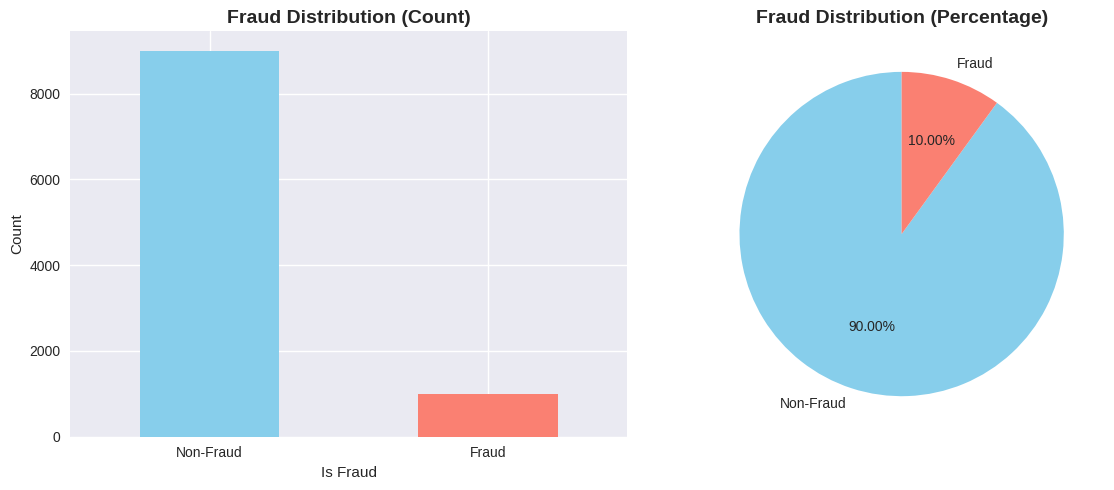

In [4]:
# Fraud distribution analysis
fraud_counts = df['is_fraud'].value_counts()
fraud_percentages = df['is_fraud'].value_counts(normalize=True) * 100

print("Fraud Distribution:")
print("=" * 30)
print(f"Non-Fraud (0): {fraud_counts[0]:,} ({fraud_percentages[0]:.2f}%)")
print(f"Fraud (1): {fraud_counts[1]:,} ({fraud_percentages[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.2f}:1")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
fraud_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Fraud Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Is Fraud')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# Pie chart
ax2.pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',
        colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('Fraud Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Feature Analysis

In [5]:
# Numerical features analysis
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# Remove target from numerical for analysis
numerical_features = [col for col in numerical_cols if col != 'is_fraud']
print(f"\nNumerical features for analysis: {numerical_features}")

Numerical columns (7): ['amount', 'hour', 'day_of_week', 'customer_age', 'is_weekend', 'log_amount', 'is_fraud']
Categorical columns (2): ['merchant_category', 'transaction_type']

Numerical features for analysis: ['amount', 'hour', 'day_of_week', 'customer_age', 'is_weekend', 'log_amount']


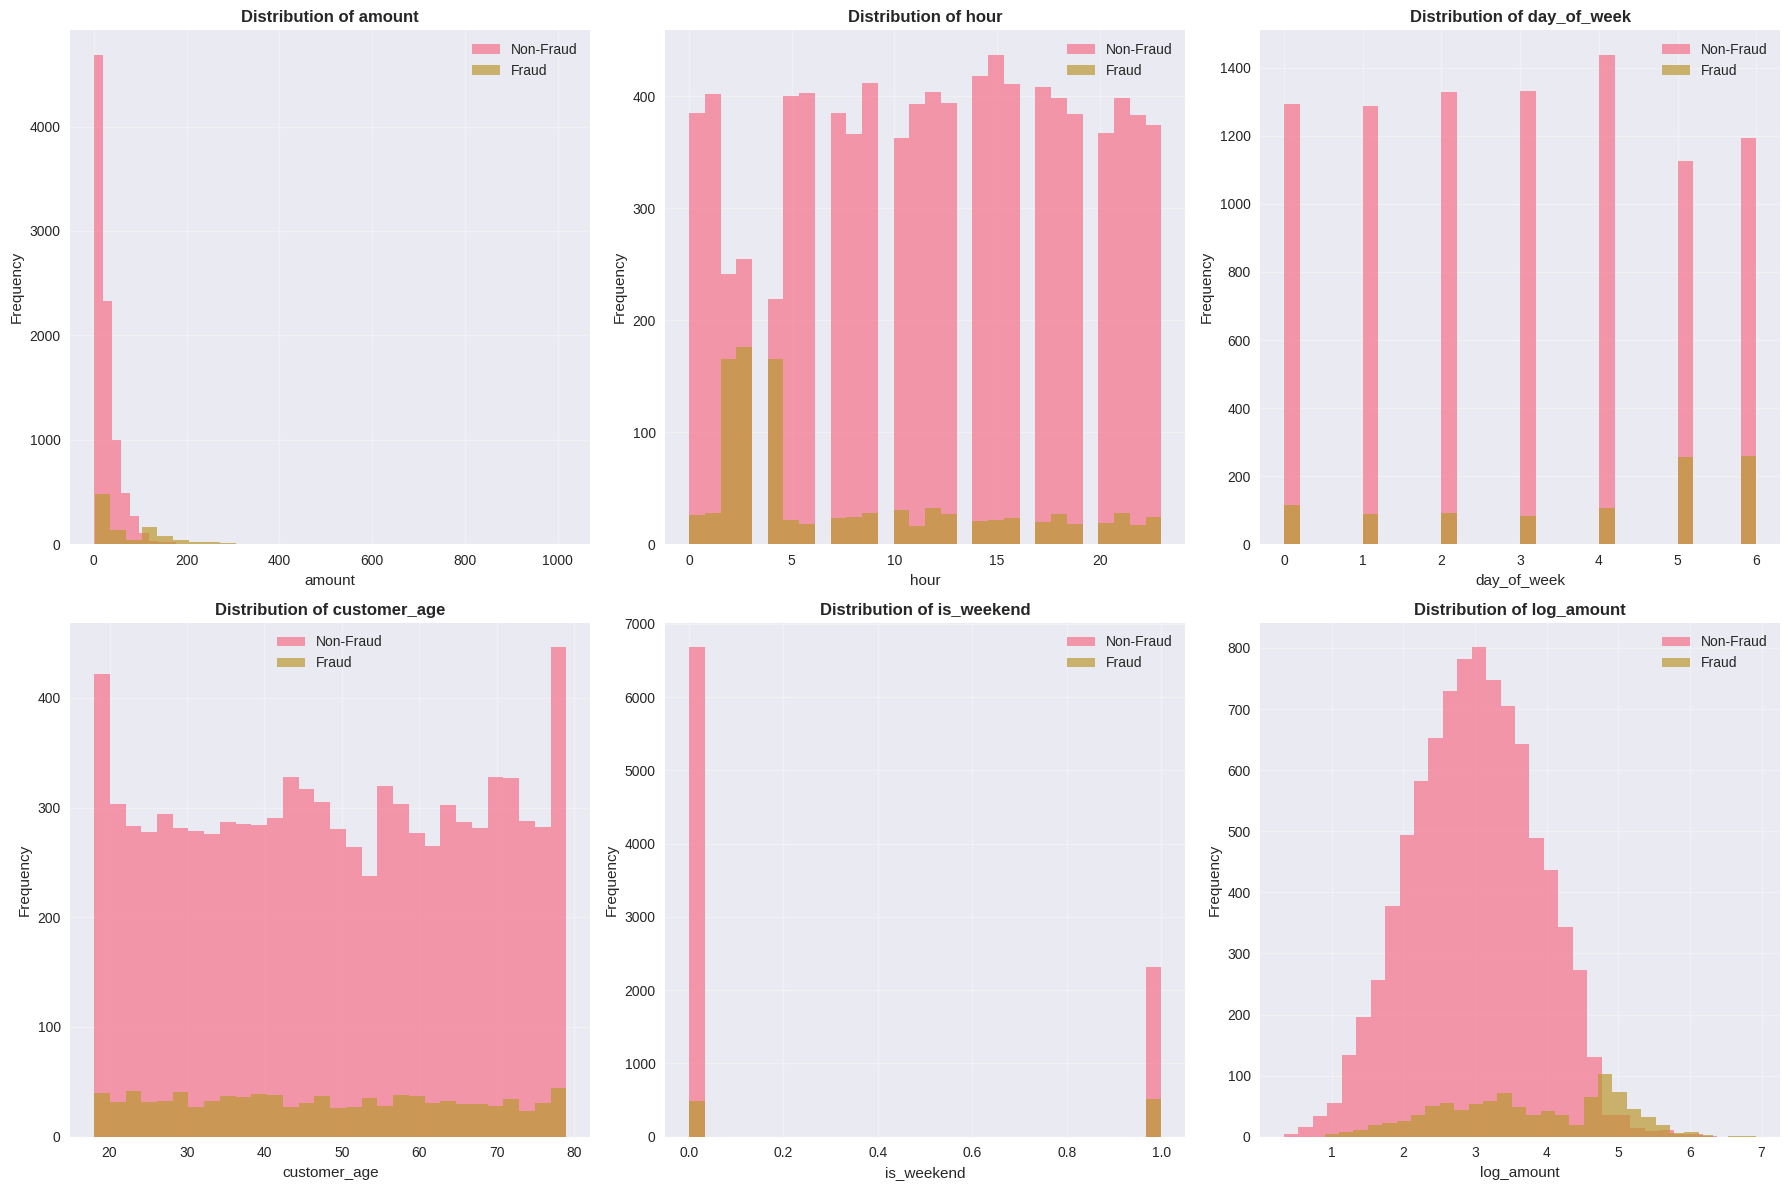

In [6]:
# Distribution of numerical features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_features):
    if i < len(axes):
        # Histogram by fraud class
        df[df['is_fraud']==0][col].hist(alpha=0.7, bins=30, label='Non-Fraud', ax=axes[i])
        df[df['is_fraud']==1][col].hist(alpha=0.7, bins=30, label='Fraud', ax=axes[i])
        
        axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

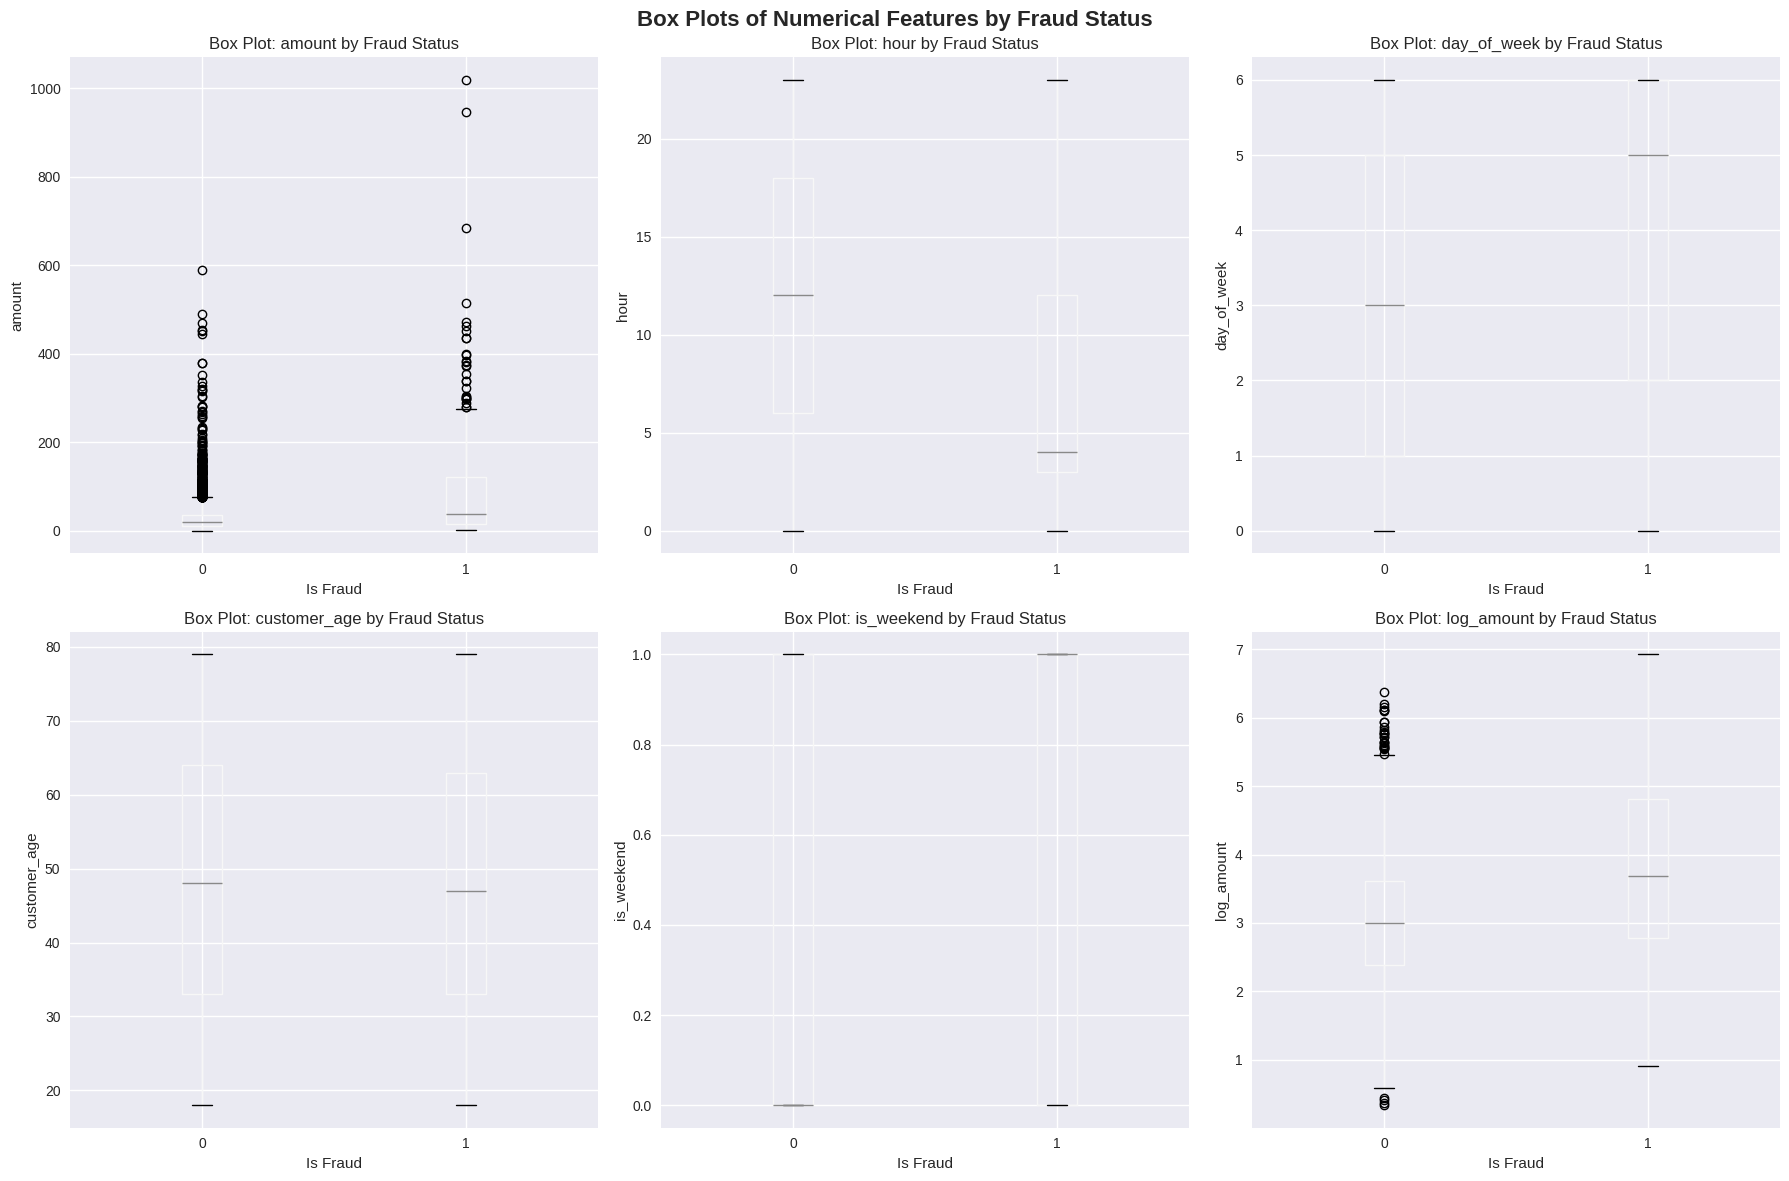

In [7]:
# Box plots for numerical features by fraud class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numerical_features):
    if i < len(axes):
        df.boxplot(column=col, by='is_fraud', ax=axes[i])
        axes[i].set_title(f'Box Plot: {col} by Fraud Status')
        axes[i].set_xlabel('Is Fraud')
        axes[i].set_ylabel(col)

# Remove empty subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Box Plots of Numerical Features by Fraud Status', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Categorical Features Analysis

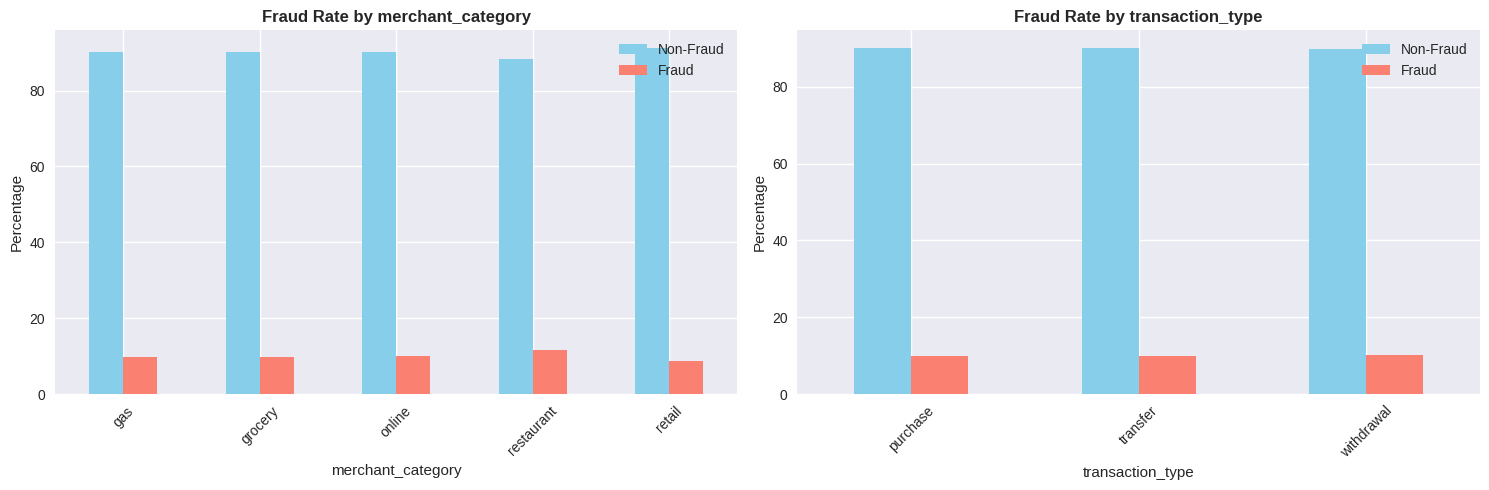


Cross-tabulation for merchant_category:
Counts:
is_fraud              0     1    All
merchant_category                   
gas                1886   207   2093
grocery            1747   190   1937
online             1891   209   2100
restaurant         1716   226   1942
retail             1760   168   1928
All                9000  1000  10000

Percentages:
is_fraud               0      1
merchant_category              
gas                90.11   9.89
grocery            90.19   9.81
online             90.05   9.95
restaurant         88.36  11.64
retail             91.29   8.71

Cross-tabulation for transaction_type:
Counts:
is_fraud             0     1    All
transaction_type                   
purchase          3030   332   3362
transfer          2989   333   3322
withdrawal        2981   335   3316
All               9000  1000  10000

Percentages:
is_fraud              0      1
transaction_type              
purchase          90.12   9.88
transfer          89.98  10.02
withdrawal     

In [8]:
# Categorical features analysis
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(15, 5))
if len(categorical_cols) == 1:
    axes = [axes]

for i, col in enumerate(categorical_cols):
    # Cross-tabulation
    crosstab = pd.crosstab(df[col], df['is_fraud'], normalize='index') * 100
    
    crosstab.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    axes[i].set_title(f'Fraud Rate by {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage')
    axes[i].legend(['Non-Fraud', 'Fraud'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print detailed cross-tabulations
for col in categorical_cols:
    print(f"\nCross-tabulation for {col}:")
    print("=" * 40)
    crosstab = pd.crosstab(df[col], df['is_fraud'], margins=True)
    crosstab_pct = pd.crosstab(df[col], df['is_fraud'], normalize='index') * 100
    print("Counts:")
    print(crosstab)
    print("\nPercentages:")
    print(crosstab_pct.round(2))

## 5. Correlation Analysis

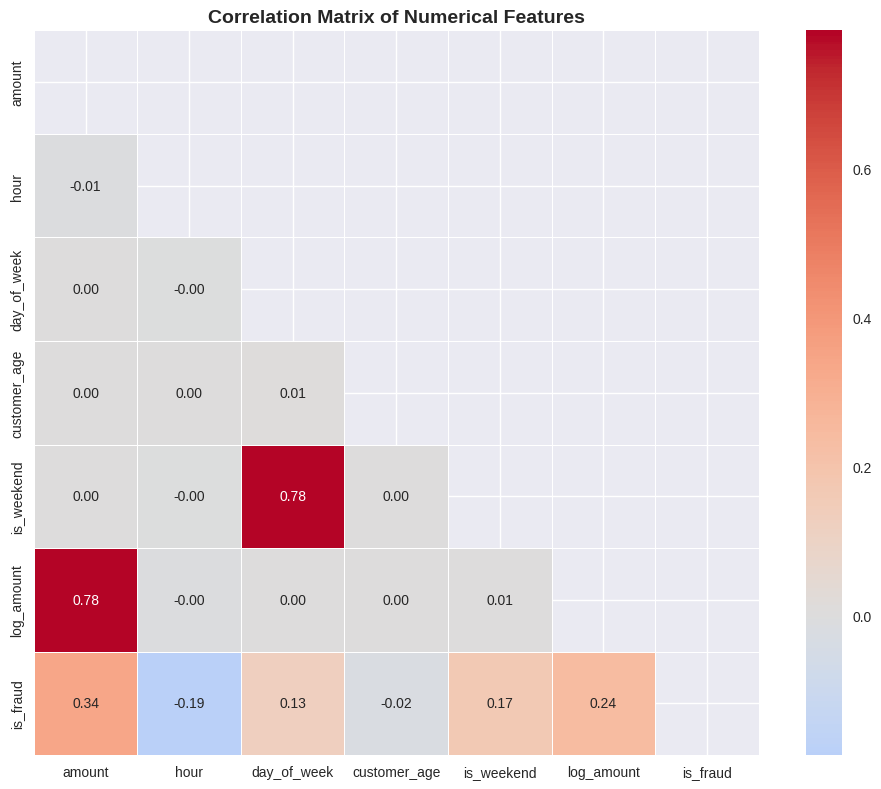


Feature Correlation with Fraud:
amount: 0.3385
log_amount: 0.2401
hour: -0.1866
is_weekend: 0.1711
day_of_week: 0.1256
customer_age: -0.0165


In [9]:
# Correlation matrix for numerical features
correlation_matrix = df[numerical_cols].corr()

# Heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature correlation with target
target_correlation = correlation_matrix['is_fraud'].drop('is_fraud').sort_values(key=abs, ascending=False)
print("\nFeature Correlation with Fraud:")
print("=" * 40)
for feature, corr in target_correlation.items():
    print(f"{feature}: {corr:.4f}")

## 6. Time-based Analysis

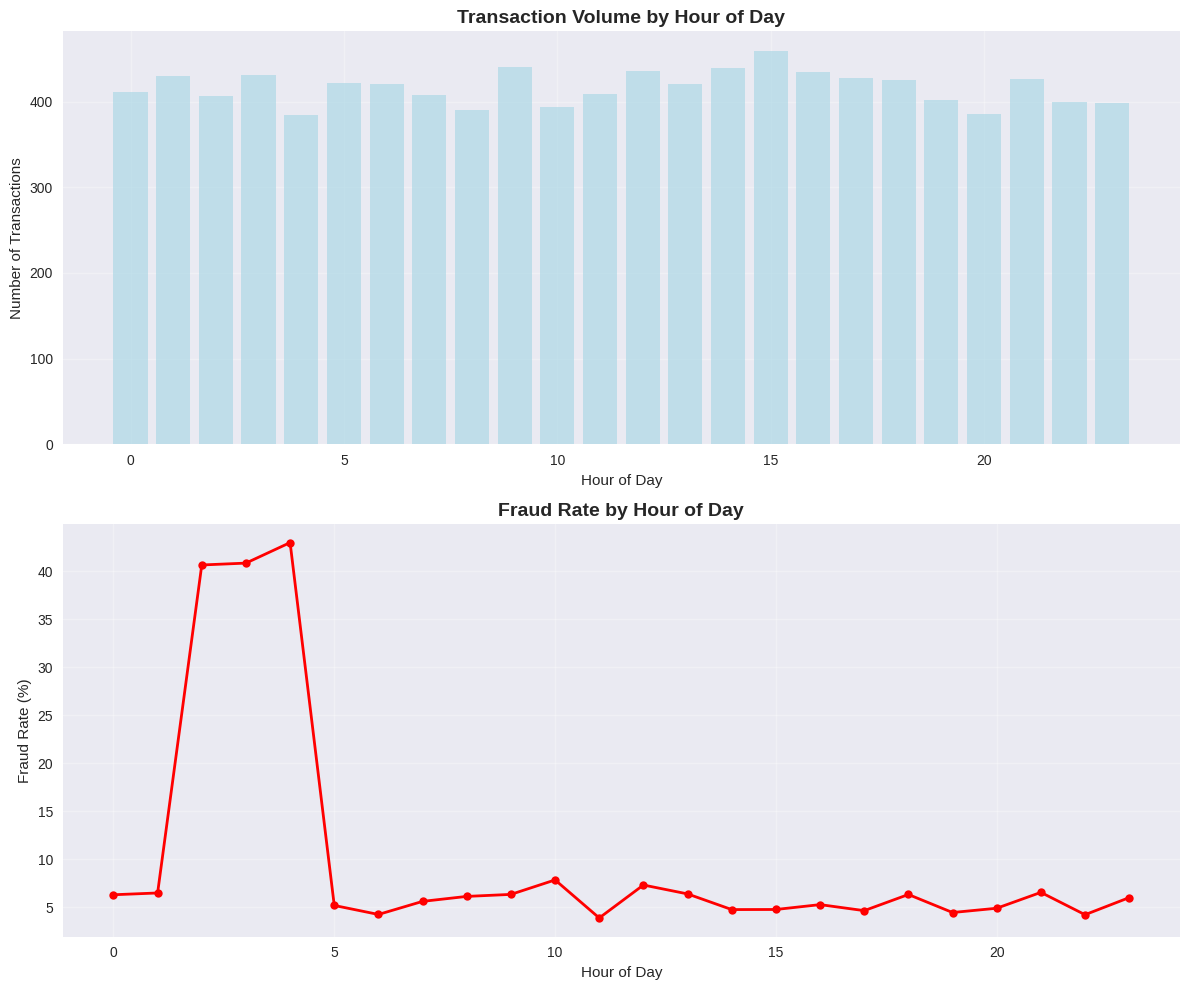


Hour with highest fraud rate:
Hour 4.0: 42.97% fraud rate


In [10]:
# Hour of day analysis
if 'hour' in df.columns:
    hour_fraud_rate = df.groupby('hour')['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()
    hour_fraud_rate['fraud_rate'] = hour_fraud_rate['mean'] * 100
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Transaction volume by hour
    ax1.bar(hour_fraud_rate['hour'], hour_fraud_rate['count'], alpha=0.7, color='lightblue')
    ax1.set_title('Transaction Volume by Hour of Day', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Transactions')
    ax1.grid(True, alpha=0.3)
    
    # Fraud rate by hour
    ax2.plot(hour_fraud_rate['hour'], hour_fraud_rate['fraud_rate'], 
             marker='o', linewidth=2, markersize=6, color='red')
    ax2.set_title('Fraud Rate by Hour of Day', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Fraud Rate (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nHour with highest fraud rate:")
    max_fraud_hour = hour_fraud_rate.loc[hour_fraud_rate['fraud_rate'].idxmax()]
    print(f"Hour {max_fraud_hour['hour']}: {max_fraud_hour['fraud_rate']:.2f}% fraud rate")

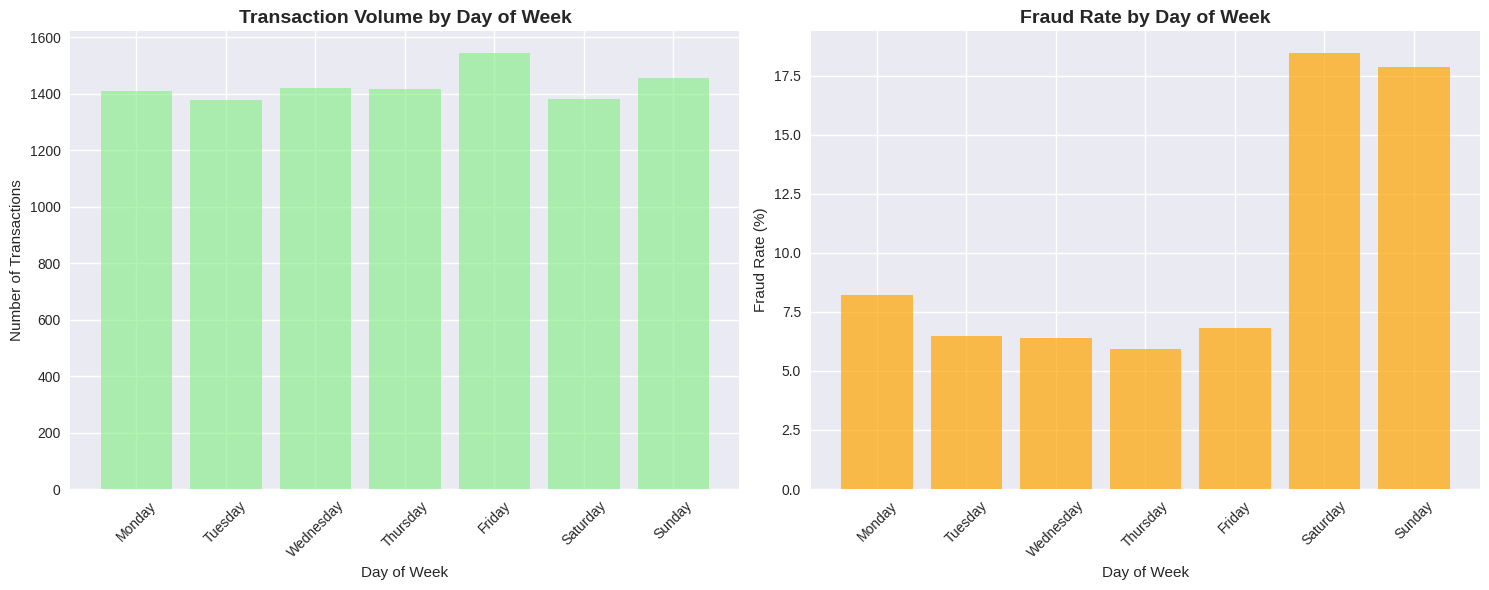

In [11]:
# Day of week analysis
if 'day_of_week' in df.columns:
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_fraud_rate = df.groupby('day_of_week')['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()
    dow_fraud_rate['fraud_rate'] = dow_fraud_rate['mean'] * 100
    dow_fraud_rate['day_name'] = dow_fraud_rate['day_of_week'].map(lambda x: day_names[x])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Transaction volume by day of week
    ax1.bar(dow_fraud_rate['day_name'], dow_fraud_rate['count'], alpha=0.7, color='lightgreen')
    ax1.set_title('Transaction Volume by Day of Week', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Day of Week')
    ax1.set_ylabel('Number of Transactions')
    ax1.tick_params(axis='x', rotation=45)
    
    # Fraud rate by day of week
    ax2.bar(dow_fraud_rate['day_name'], dow_fraud_rate['fraud_rate'], alpha=0.7, color='orange')
    ax2.set_title('Fraud Rate by Day of Week', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Fraud Rate (%)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## 7. Amount Analysis

Transaction Amount Statistics by Fraud Status:
           count       mean        std       min        25%        50%  \
is_fraud                                                                 
0         9000.0  28.233215  31.197923  0.397564   9.853379  19.096032   
1         1000.0  77.899090  91.700460  1.465017  15.212488  39.140405   

                 75%          max  
is_fraud                           
0          36.175288   588.385838  
1         121.333303  1018.654285  


/tmp/ipykernel_133813/492323397.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  amount_fraud_rate = df.groupby('amount_range')['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()


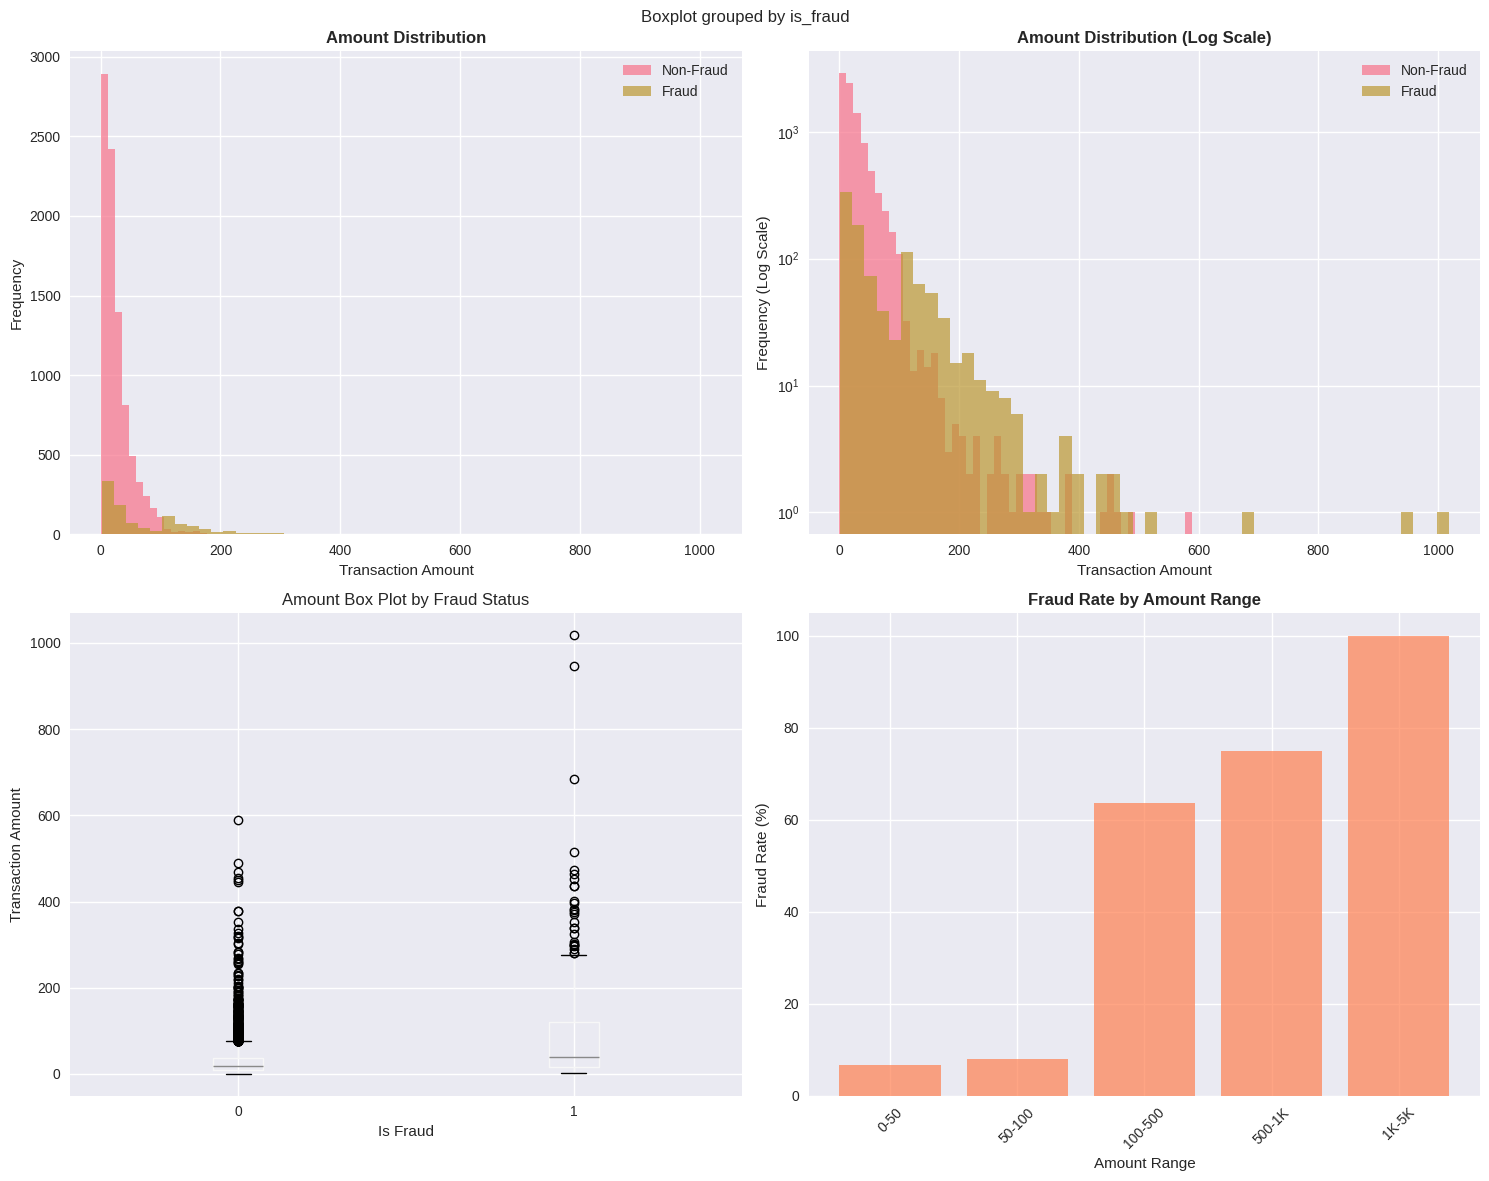


Fraud Rate by Amount Range:
0-50: 6.67% (546/8190 transactions)
50-100: 8.10% (102/1259 transactions)
100-500: 63.74% (348/546 transactions)
500-1K: 75.00% (3/4 transactions)
1K-5K: 100.00% (1/1 transactions)
5K+: nan% (0/0 transactions)


In [12]:
# Transaction amount analysis
if 'amount' in df.columns:
    # Statistical comparison
    amount_stats = df.groupby('is_fraud')['amount'].describe()
    print("Transaction Amount Statistics by Fraud Status:")
    print("=" * 60)
    print(amount_stats)
    
    # Amount distribution by fraud status
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Histogram
    df[df['is_fraud']==0]['amount'].hist(bins=50, alpha=0.7, label='Non-Fraud', ax=axes[0,0])
    df[df['is_fraud']==1]['amount'].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[0,0])
    axes[0,0].set_title('Amount Distribution', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Transaction Amount')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # Log-scale histogram
    df[df['is_fraud']==0]['amount'].hist(bins=50, alpha=0.7, label='Non-Fraud', ax=axes[0,1])
    df[df['is_fraud']==1]['amount'].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[0,1])
    axes[0,1].set_yscale('log')
    axes[0,1].set_title('Amount Distribution (Log Scale)', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Transaction Amount')
    axes[0,1].set_ylabel('Frequency (Log Scale)')
    axes[0,1].legend()
    
    # Box plot
    df.boxplot(column='amount', by='is_fraud', ax=axes[1,0])
    axes[1,0].set_title('Amount Box Plot by Fraud Status')
    axes[1,0].set_xlabel('Is Fraud')
    axes[1,0].set_ylabel('Transaction Amount')
    
    # Amount ranges analysis
    amount_bins = [0, 50, 100, 500, 1000, 5000, float('inf')]
    amount_labels = ['0-50', '50-100', '100-500', '500-1K', '1K-5K', '5K+']
    df['amount_range'] = pd.cut(df['amount'], bins=amount_bins, labels=amount_labels, include_lowest=True)
    
    amount_fraud_rate = df.groupby('amount_range')['is_fraud'].agg(['count', 'sum', 'mean']).reset_index()
    amount_fraud_rate['fraud_rate'] = amount_fraud_rate['mean'] * 100
    
    axes[1,1].bar(amount_fraud_rate['amount_range'], amount_fraud_rate['fraud_rate'], 
                  alpha=0.7, color='coral')
    axes[1,1].set_title('Fraud Rate by Amount Range', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Amount Range')
    axes[1,1].set_ylabel('Fraud Rate (%)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nFraud Rate by Amount Range:")
    print("=" * 40)
    for _, row in amount_fraud_rate.iterrows():
        print(f"{row['amount_range']}: {row['fraud_rate']:.2f}% ({row['sum']}/{row['count']} transactions)")

## 8. Key Insights and Recommendations

In [13]:
# Summary of key insights
print("KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Class imbalance
fraud_rate = df['is_fraud'].mean() * 100
print(f"1. CLASS IMBALANCE:")
print(f"   • Overall fraud rate: {fraud_rate:.2f}%")
print(f"   • This is a highly imbalanced dataset - consider SMOTE, class weights, or threshold tuning")

# Feature importance insights
print(f"\n2. FEATURE CORRELATIONS:")
if 'amount' in numerical_cols:
    amount_corr = df['amount'].corr(df['is_fraud'])
    print(f"   • Amount correlation with fraud: {amount_corr:.4f}")
    
if 'hour' in numerical_cols:
    hour_corr = df['hour'].corr(df['is_fraud'])
    print(f"   • Hour correlation with fraud: {hour_corr:.4f}")

# Categorical insights
print(f"\n3. CATEGORICAL PATTERNS:")
for col in categorical_cols:
    fraud_rates_by_cat = df.groupby(col)['is_fraud'].mean() * 100
    max_fraud_cat = fraud_rates_by_cat.idxmax()
    max_fraud_rate = fraud_rates_by_cat.max()
    print(f"   • Highest fraud rate in {col}: {max_fraud_cat} ({max_fraud_rate:.2f}%)")

print(f"\n4. RECOMMENDATIONS FOR MODELING:")
print(f"   • Use stratified sampling to maintain class distribution")
print(f"   • Consider ensemble methods that handle imbalanced data well")
print(f"   • Feature engineering: time-based features, amount ratios")
print(f"   • Evaluation metrics: Precision, Recall, F1-Score, AUC-ROC")
print(f"   • Cross-validation with stratification")

print(f"\n" + "=" * 50)
print(f"EDA COMPLETED SUCCESSFULLY!")
print(f"Dataset is ready for modeling phase.")

KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS
1. CLASS IMBALANCE:
   • Overall fraud rate: 10.00%
   • This is a highly imbalanced dataset - consider SMOTE, class weights, or threshold tuning

2. FEATURE CORRELATIONS:
   • Amount correlation with fraud: 0.3385
   • Hour correlation with fraud: -0.1866

3. CATEGORICAL PATTERNS:
   • Highest fraud rate in merchant_category: restaurant (11.64%)
   • Highest fraud rate in transaction_type: withdrawal (10.10%)

4. RECOMMENDATIONS FOR MODELING:
   • Use stratified sampling to maintain class distribution
   • Consider ensemble methods that handle imbalanced data well
   • Feature engineering: time-based features, amount ratios
   • Evaluation metrics: Precision, Recall, F1-Score, AUC-ROC
   • Cross-validation with stratification

EDA COMPLETED SUCCESSFULLY!
Dataset is ready for modeling phase.
